# **Booster Challenge- Etape 1 : Détection d’un parking.**
La génération d’électricité par voie photovoltaïque est une solution d’avenir dont la compétitivité vis-à-vis des solutions de générations électriques conventionnelles ne cesse de s’accroitre. Le Groupe Total devient un acteur majeur de cette filière. Sa filiale à 100% GreenFlex réalise pour le compte de ses clients des études d’opportunité photovoltaïque sur de larges parcs de sites.



Un outil d’analyse semi-automatisé, PV Explorer, a déjà été développé afin d’identifier rapidement les bâtiments les plus propices à la solarisation dans le périmètre étudié, d’un point de vue technique et économique.

La réalisation de cette analyse technico-économique est notamment basée sur un repérage automatique de la surface disponible et des obstacles alentours pris en compte dans le calcul d’ombrage. Aujourd’hui, cette automatisation est possible uniquement dans le cas de bâtiments existants, l’outil faisant appel à une base de données de l’IGN.

Il n’existe pas de base de données équivalente recensant les parkings, zones généralement propices à l’installation de centrales photovoltaïques. Ainsi, la possibilité d’identification automatique de la surface de parking d’un site, de son orientation et de ses obstacles végétaux présenterait un fort intérêt dans le cadre de ces études multisite, représentant un gain de temps considérable. L’obectif du challenge est de fournir une telle solution à GreenFlex !

Le challenge est divisé en 3 étapes. Tu peux participer à une ou plusieurs d’entre elles.



> **Step 1** : Détection d’un parking sur une image satellite.
Du 25/11 au 15/12. Meet-Up le 16/12 à 13:00


## Install System

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/My Drive/ParkingRocognition')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import optimizers, initializers, regularizers
from keras.layers import Input, Dense, BatchNormalization, Conv2D, \
    MaxPooling2D,\
    Flatten, UpSampling2D, GaussianNoise,\
    Reshape, Lambda, Add, concatenate,\
    Dropout, LeakyReLU, Activation, GlobalAveragePooling2D, PReLU, Softmax, \
    Multiply
from keras.models import model_from_json, Model 
import UtilsFunction as UF
from keras_applications.resnext import ResNeXt50, ResNeXt101
from keras_applications.nasnet import NASNetLarge
from keras_applications import inception_resnet_v2
from keras_applications.vgg19 import VGG19
from keras.preprocessing import image
import keras
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize, rescale

from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.callbacks import History

from tqdm import tqdm_notebook, tqdm

os.environ['KMP_DUPLICATE_LIB_OK']='True'

os.chdir('/content/drive/My Drive/ParkingRocognition')

os.getcwd()

Using TensorFlow backend.


'/content/drive/My Drive/ParkingRocognition'

## Creating Data Pickle

### Train and Validation sets

In [0]:
# -----------------------
# Data train Import
# -----------------------
df = pd.read_csv("./Challenge_Data/train.csv", sep=';')
Y_train = df['has_parking'].values

image_name = df['id']

np.save('filenames.npy', image_name)
np.save('y_train.npy', Y_train)

df = pd.read_csv("./Challenge_Data/holdout.csv", sep=';')
image_name_test = df['id']
np.save('filenames_test.npy', image_name_test)

filenames_shuffled, Y_train_shuffled = shuffle(image_name, Y_train)

# saving the shuffled file.
np.save('y_train_shuffled.npy', Y_train_shuffled)
np.save('filenames_shuffled.npy', filenames_shuffled)

filenames_shuffled_numpy = np.array(filenames_shuffled)

X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(
    filenames_shuffled_numpy, Y_train_shuffled, test_size=0.2, random_state=1)

print(X_train_filenames.shape) 
print(y_train.shape)           

print(X_val_filenames.shape)   
print(y_val.shape)             

# You can save these files as well. As you will be using them later for training and validation of your model.
np.save('X_train_filenames.npy', X_train_filenames)
np.save('y_train.npy', y_train)

np.save('X_val_filenames.npy', X_val_filenames)
np.save('y_val.npy', y_val)

In [0]:
Builder_train = UF.DataBuilding(X_train_filenames, y_train)
Builder_val   = UF.DataBuilding(X_val_filenames, y_val)

X_train, y_train = Builder_train.__getitem__(size=5000, 
                                             path='./Challenge_Data/TRAIN/',
                                             image_shape=(224, 224, 3),
                                             name='train_%d_equi.pickle')
X_val, y_val     = Builder_val.__getitem__(size=1440, 
                                           path='./Challenge_Data/TRAIN/',
                                           image_shape=(224, 224, 3),
                                           name='val_%d_equi.pickle')

### Test

In [0]:
# -----------------------
# Data test Import
# -----------------------
image_name_test = pd.read_csv("./Challenge_Data/holdout.csv", sep=';')['id']

X_test = UF.import_data(path='./Challenge_Data/HOLDOUT/', ids=image_name_test, size=(224, 224, 3))/255.

In [0]:
with open('test_tot.pickle', 'wb') as f:
  pickle.dump([X_test], f, protocol=4)

## Load Data Pickle

In [0]:
with open('train_5000_equi.pickle', 'rb') as f:
    X_train, Y_train = pickle.load(f)

with open('val_1440_equi.pickle', 'rb') as f:
    X_val, y_val = pickle.load(f)

In [0]:
with open('test_tot.pickle', 'rb') as f:
    X_test = pickle.load(f)[0]

## Create Meta data

In [0]:
X_train_features = UF.features_extraction(X = X_train).calcul_features()
X_val_features   = UF.features_extraction(X = X_val).calcul_features()

In [0]:
X_train_features.to_csv('X_train_features.csv',index=False)
X_val_features.to_csv('X_val_features.csv',index=False)

In [0]:
X_test_features = UF.features_extraction(X = X_test).calcul_features()
X_test_features.to_csv('X_test_features.csv',index=False)

# Network Processing

## Building Pipeline

In [0]:
input_shape = (224, 224, 3)

learning_rate = 0.00003

Early = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

optimizer = optimizers.Adam(lr=learning_rate)

In [0]:
class UpsampleLike(keras.layers.Layer):
    """ Keras layer for upsampling a Tensor to be the same shape as another Tensor.
    """

    def call(self, inputs, **kwargs):
        source, target = inputs
        target_shape = keras.backend.int_shape(target)
        source_shape = keras.backend.int_shape(source)
        if keras.backend.image_data_format() == 'channels_first':
            source = keras.backend.transpose(source, (0, 2, 3, 1))
            output = keras.backend.resize_images(source, 
                                                 height_factor=int(target_shape[2]\
                                                                   /source_shape[2]), 
                                                 width_factor=int(target_shape[3]\
                                                                  /source_shape[3]), 
                                                 interpolation='nearest', 
                                                 data_format='channels_last')
            output = keras.backend.transpose(output, (0, 3, 1, 2))
            return output
        else:
            return keras.backend.resize_images(source, 
                                               height_factor=int(target_shape[1]\
                                                                 /source_shape[1]), 
                                               width_factor=int(target_shape[2]\
                                                                /source_shape[2]), 
                                               interpolation='nearest', 
                                               data_format='channels_last')

    def compute_output_shape(self, input_shape):
        if keras.backend.image_data_format() == 'channels_first':
            return (input_shape[0][0], input_shape[0][1]) + input_shape[1][2:4]
        else:
            return (input_shape[0][0],) + input_shape[1][1:3] + (input_shape[0][-1],)

def __create_pyramid_features(C3, C4, C5, feature_size=256):
    """ Creates the FPN layers on top of the backbone features.
    Args
        C3           : Feature stage C3 from the backbone.
        C4           : Feature stage C4 from the backbone.
        C5           : Feature stage C5 from the backbone.
        feature_size : The feature size to use for the resulting feature levels.
    Returns
        A list of feature levels [P3, P4, P5, P6, P7].
    """
    # upsample C5 to get P5 from the FPN paper
    P5           = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C5_reduced')(C5)
    P5_upsampled = UpsampleLike(name='P5_upsampled')([P5, C4])
    P5           = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P5')(P5)

    # add P5 elementwise to C4
    P4           = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C4_reduced')(C4)
    P4           = keras.layers.Add(name='P4_merged')([P5_upsampled, P4])
    P4_upsampled = UpsampleLike(name='P4_upsampled')([P4, C3])
    P4           = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P4')(P4)

    # add P4 elementwise to C3
    P3 = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C3_reduced')(C3)
    P3 = keras.layers.Add(name='P3_merged')([P4_upsampled, P3])
    P3 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P3')(P3)

    # "P6 is obtained via a 3x3 stride-2 conv on C5"
    P6 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P6')(C5)

    # "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
    P7 = keras.layers.Activation('relu', name='C6_relu')(P6)
    P7 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P7')(P7)

    return [P3, P4, P5, P6, P7]

def classification_model(input_shape=(None, None, 256),
                         pyramid_feature_size=256,
                         prior_probability=0.01,
                         classification_feature_size=256):
  """ Creates the default classification submodel.
  Args
      num_classes                 : Number of classes to predict a score for at each feature level.
      num_anchors                 : Number of anchors to predict classification scores for at each feature level.
      pyramid_feature_size        : The number of filters to expect from the feature pyramid levels.
      classification_feature_size : The number of filters to use in the layers in the classification submodel.
      name                        : The name of the submodel.
  Returns
      A keras.models.Model that predicts classes for each anchor.
  """
  options = {
      'kernel_size' : 3,
      'strides'     : 1,
      'padding'     : 'same',
  }


  inputs  = keras.layers.Input(shape=input_shape)
  outputs = inputs
  for i in range(4):
      outputs = keras.layers.Conv2D(
          filters=classification_feature_size,
          kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None),
          bias_initializer='zeros',
          **options
      )(outputs)
      outputs = BatchNormalization()(outputs)
      outputs = Activation('relu')(outputs)
      
  # reshape output and apply sigmoid
  outputs = x = GlobalAveragePooling2D()(outputs)
  outputs = keras.layers.Activation('selu')(outputs)

  return keras.models.Model(inputs=inputs, outputs=outputs)

import math


class PriorProbability(keras.initializers.Initializer):
    """ Apply a prior probability to the weights.
    """

    def __init__(self, probability=0.01):
        self.probability = probability

    def get_config(self):
        return {
            'probability': self.probability
        }

    def __call__(self, shape, dtype=None):
        # set bias to -log((1 - p)/p) for foreground
        result = np.ones(shape, dtype=dtype) * -math.log((1 - self.probability) / self.probability)

        return result

In [56]:
model = ResNeXt101(weights='imagenet',
                    backend=keras.backend,
                    layers=keras.layers,
                    models=keras.models,
                    utils=keras.utils,
                    include_top=False,
                    input_tensor=Input(shape=input_shape))

#39 111 435 476                                           
C5 = model.layers[476].output
C4 = model.layers[432].output
C3 = model.layers[108].output

[P3, P4, P5, P6, P7] = __create_pyramid_features(C3, C4, C5, feature_size=256)


both = concatenate([classification_model(input_shape=K.int_shape(f)[1:],
                                         classification_feature_size=256)(f) \
                    for f in [P3, P4, P5, P6, P7]])

both = Dense(1024, 
             activation='selu',
             kernel_initializer=keras.initializers.normal(mean=0.0, 
                                                          stddev=0.01, 
                                                          seed=None))(both)
both = Dropout(0.5)(both)


both = Dense(512, 
             activation='selu',
             kernel_initializer=keras.initializers.normal(mean=0.0, 
                                                          stddev=0.01, 
                                                          seed=None))(both)
both = Dropout(0.3)(both)


output_layer = Dense(1, activation='sigmoid', 
                     kernel_initializer='glorot_uniform')(both)

Discriminator = Model(inputs=model.input, outputs=output_layer)

#for layer in model.layers:
#  layer.trainable = False
Discriminator.compile(loss='binary_crossentropy' , 
                      optimizer=optimizer, 
                      metrics=['acc'])

Discriminator.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Train Network

In [0]:
epochs=20
batch_size=16

In [0]:
datagen = image.ImageDataGenerator(zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)
datagen.fit(X_train)
                              #width_shift_range=0.2,
                              #height_shift_range=0.2,
                              #rotation_range=20,
                              
datagen_pred = image.ImageDataGenerator()
datagen_pred.fit(X_train)

X_val_test = X_val[801:]
y_val_test = y_val[801:]
X_val = X_val[:800]
y_val = y_val[:800]

In [62]:
history = Discriminator.fit_generator(datagen.flow(X_train, 
                                                   Y_train, 
                                                   batch_size=batch_size),
                                      steps_per_epoch=int(len(X_train) // 8),
                                      epochs=epochs,
                                      shuffle=True,
                                      validation_data=datagen_pred.flow(X_val, 
                                                                   y_val, 
                                                                   batch_size=\
                                                                   batch_size),
                                      validation_steps=int(len(X_val) // 4),
                                      callbacks=[Early])

Epoch 1/20
625/625 [==============================] - 800s 1s/step - loss: 0.1539 - acc: 0.9431 - val_loss: 0.1093 - val_acc: 0.9613
Epoch 2/20
625/625 [==============================] - 755s 1s/step - loss: 0.0678 - acc: 0.9771 - val_loss: 0.0576 - val_acc: 0.9800
Epoch 3/20
625/625 [==============================] - 755s 1s/step - loss: 0.0412 - acc: 0.9841 - val_loss: 0.0246 - val_acc: 0.9900
Epoch 4/20
625/625 [==============================] - 755s 1s/step - loss: 0.0262 - acc: 0.9897 - val_loss: 0.2217 - val_acc: 0.9413


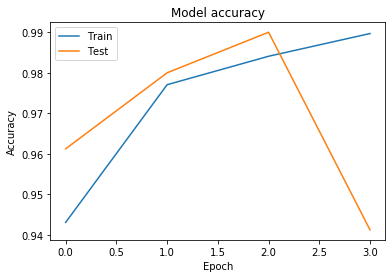

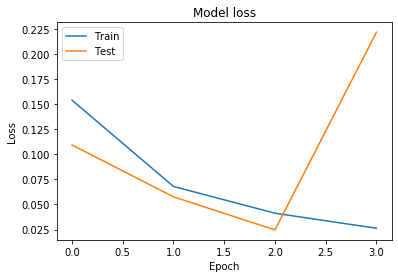

In [63]:
from keras.utils import plot_model
plot_model(Discriminator, to_file='pictures/model.png')

# Plot training & validation accuracy values
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig('pictures/acc.png')

# Plot training & validation loss values
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig('pictures/loss.png')

In [0]:
Discriminator.evaluate(X_val_test, y_val_test)

### Save Model

In [0]:
# serialize model to JSON
model_json = Discriminator.to_json()
with open("model_RetinaNet--98v11.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
Discriminator.save_weights("model_RetinaNet--98v11.h5")
print("Saved model to disk")
del model_json

### Load Model

In [14]:
# load weights into new model
Discriminator.load_weights("model_RetinaNet--98v7.h5")
print("Loaded model from disk")




Discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

Loaded model from disk


## XGBoost Regression


Redifine Disciminator Neural Net

In [0]:
Discriminator = Model(inputs= Discriminator.input, outputs=Discriminator.layers[-2].output)

### Concatenate Dataset 
From features extraction and Discriminator

In [16]:
X_train_Cl = Discriminator.predict(X_train, verbose=1)
X_val_Cl   = Discriminator.predict(X_val, verbose=1)
X_val_Cl_test = Discriminator.predict(X_val_test, verbose=1)

639/639 [==============================] - 9s 14ms/step


In [0]:
pd.DataFrame(X_train_Cl).to_csv('X_train_Cl_features.csv')
pd.DataFrame(X_val_Cl).to_csv('X_val_Cl_features.csv')
pd.DataFrame(X_val_Cl_test).to_csv('X_val_test_Cl_features.csv')

In [0]:
X_train_Cl = pd.read_csv('X_train_Cl_features.csv')
X_val_Cl   = pd.read_csv('X_val_Cl_features.csv')
X_val_test_Cl   = pd.read_csv('X_val_test_Cl_features.csv')
X_train_features = pd.read_csv('X_train_features.csv')
X_val_features   = pd.read_csv('X_val_features.csv').iloc[:800]
X_val_test_features   = pd.read_csv('X_val_features.csv').iloc[801:].reset_index()

In [0]:
X_train_features[['Disc_%d'%(i) \
                  for i in range(X_train_Cl.shape[1]-1)]] = \
                  X_train_Cl.iloc[:,1:]
X_val_features[['Disc_%d'%(i) \
                for i in range(X_val_Cl.shape[1]-1)]] = X_val_Cl.iloc[:,1:]
X_val_test_features[['Disc_%d'%(i) \
                    for i in range(X_val_test_Cl.shape[1]-1)]] = \
                    X_val_test_Cl.iloc[:,1:]

X_train_Cl      = X_train_features
X_val_Cl        = X_val_features
X_val_test_Cl   = X_val_test_features
X_val_test_Cl   = X_val_test_Cl.iloc[:,1:]

del X_train_features, X_val_features, X_val_test_features

### Bayesian Optimization For XGBOOST

In [0]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train_Cl,label=Y_train)

In [21]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate):
  params = {'max_depth': int(max_depth),
          'gamma': gamma,
          'n_estimators': int(n_estimators),
          'learning_rate':learning_rate,
          'subsample': 0.8,
          'eta': 0.1,
          'eval_metric': 'rmse',
          'objective': 'binary:logistic'}
  #Cross validating with the specified parameters in 5 folds and 70 iterations
  cv_result = xgb.cv(params, dtrain, num_boost_round=20, nfold=5)
  #Return the negative RMSE
  return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=2d4a1cb2bbd1b8eacbb7d9223a7edae836021f9b5c53d58162e889087774101b
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [22]:
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (2, 10), 
                                             'gamma': (0, 1),
                                             'learning_rate':(0.0001,1),
                                             'n_estimators':(100,500)
                                            })

#performing Bayesian optimization for 5 iterations with 8 randoms steps
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.05756  |  0.8269   |  0.438    |  4.031    |  350.2    |
|  2        | -0.06419  |  0.8736   |  0.1446   |  8.845    |  398.3    |
|  3        | -0.05716  |  0.5169   |  0.5059   |  5.369    |  404.4    |
|  4        | -0.05638  |  0.3422   |  0.4136   |  8.971    |  486.1    |
|  5        | -0.1864   |  0.07202  |  0.05086  |  2.145    |  132.1    |
|  6        | -0.06045  |  0.3329   |  0.4775   |  8.236    |  190.2    |
|  7        | -0.06301  |  0.9153   |  0.1519   |  8.375    |  407.7    |
|  8        | -0.06066  |  0.3623   |  0.1723   |  7.262    |  215.4    |
|  9        | -0.05929  |  0.2051   |  0.3614   |  2.032    |  498.6    |
|  10       | -0.06091  |  0.0202   |  0.8927   |  2.152    |  460.3    |
|  11       | -0.06525  |  0.02496  |  0.9753   |  2.057    |  374.0    |
|  12       | -0.06208  |  0.04876  | 

In [0]:
params = xgb_bo.max['params']
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

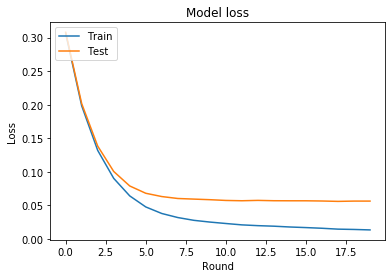

In [24]:
def bo_tune_xgb2(max_depth, gamma, n_estimators ,learning_rate):
  params = {'max_depth': int(max_depth),
          'gamma': gamma,
          'n_estimators': int(n_estimators),
          'learning_rate':learning_rate,
          'subsample': 0.8,
          'eta': 0.1,
          'eval_metric': 'rmse',
          'objective': 'binary:logistic'}
  #Cross validating with the specified parameters in 5 folds
  cv_result = xgb.cv(params, dtrain, num_boost_round=20, nfold=5)
  #Return the negative RMSE
  return cv_result

res = bo_tune_xgb2(**params)


# Plot training & validation loss values
fig = plt.figure()
plt.plot(res['train-rmse-mean'])
plt.plot(res['test-rmse-mean'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Round')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig('pictures/XG_boost_loss.png')

In [0]:
bst=xgb.XGBClassifier(**params, n_jobs=-1, num_round=2)
bst.fit(X_train_Cl, Y_train)

bst.save_model('to_try2.model')

(array([523.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.05607685, 0.11215369, 0.16823055, 0.22430739,
        0.28038424, 0.3364611 , 0.39253795, 0.44861478, 0.50469166,
        0.5607685 ], dtype=float32),
 <a list of 10 Patch objects>)

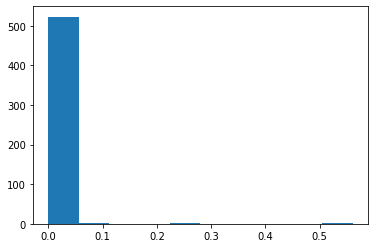

In [26]:
plt.hist(bst.feature_importances_)

In [27]:
y_pred = bst.predict(X_val_Cl)
predictions = [round(value) for value in y_pred]
# evaluate predictions
Score = 1 - np.mean(np.abs(y_pred.reshape(y_pred.shape[0])-y_val))
print("Accuracy: %.2f%%" % (Score * 100.0))

Accuracy: 98.00%


(array([400.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 400.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

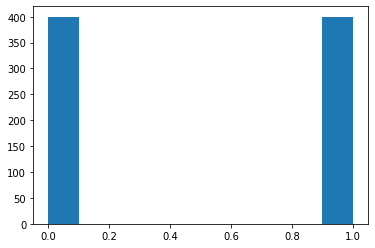

In [28]:
ypred2 = np.copy(predictions)
plt.hist(ypred2)
#plt.hist(y_val)

In [29]:
y_pred = bst.predict(X_val_test_Cl)
predictions = [round(value) for value in y_pred]
# evaluate predictions
Score = 1 - np.mean(np.abs(y_pred.reshape(y_pred.shape[0])-y_val_test))
print("Accuracy: %.2f%%" % (Score * 100.0))

Accuracy: 98.12%


(array([326.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 313.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

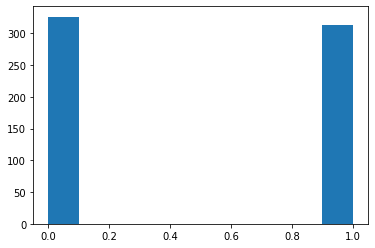

In [30]:
ypred2 = np.copy(predictions)
plt.hist(ypred2)
#plt.hist(y_val_test)

In [31]:
  input_shape=(224, 224, 3)
  inte = np.random.randint(0, X_val_test_Cl.shape[0], 100)

  fig = plt.figure(figsize=(20, 120))
  for j in range(len(inte)):
      axs = fig.add_subplot(50, 2, j + 1)
      plt.imshow(X_val_test[inte[j]].reshape(input_shape))
      plt.text(280, 25, '[pred: %f]' % (float(y_pred[inte[j]])), va="top", family="monospace")
      plt.text(280, 50, '[true: %f]' % (y_val_test[inte[j]]), va="top", family="monospace")
      plt.xlim(0, 480)
  fig.savefig("pictures/results_" + 'val' + ".png")

Output hidden; open in https://colab.research.google.com to view.

## PREDICTION ON TEST

In [0]:
with open('test_tot.pickle', 'rb') as f:
    X_test = pickle.load(f)[0]

It has to be the Decriminator without the sigmoid last dense layer

In [33]:
X_test_Cl = Discriminator.predict(X_test, verbose=1)

3073/3073 [==============================] - 44s 14ms/step


In [0]:
pd.DataFrame(X_test_Cl).to_csv('X_test_Cl.csv')

In [0]:
X_test_Cl   = pd.read_csv('X_test_Cl.csv')
X_test_features   = pd.read_csv('X_test_features.csv')

#X_test_features['Disc'] = X_test_Cl.iloc[:,1]
X_test_features[['Disc_%d'%(i) \
                 for i in range(X_test_Cl.shape[1]-1)]] = X_test_Cl.iloc[:,1:]

X_test_Cl = X_test_features

del X_test_features

In [0]:
pred = bst.predict(X_test_Cl)

In [0]:
pred_test = np.copy(pred)

In [0]:
pred = np.copy(pred_test)

In [0]:
image_name_test = pd.read_csv("./Challenge_Data/holdout.csv", sep=';')['id']

Create the output file

In [43]:
output = pd.DataFrame(np.concatenate(((np.array(pred)).reshape(len(pred), 1), 
                                      (np.array(pred).astype(int)).reshape(len(pred), 1)), 
                                     axis=1))
output.iloc[:,0] = image_name_test 

output.columns = ['id', 'has_parking']

output['has_parking'] = output['has_parking'].astype('int32')
print(output.dtypes)

output.to_csv('output.csv', index=False, sep=';')

id             object
has_parking     int32
dtype: object


(array([ 923.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2150.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

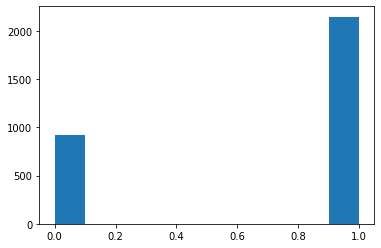

In [38]:
plt.hist(pred_test)

In [39]:
input_shape=(224, 224, 3)
inte = np.random.randint(0, X_test.shape[0], 100)

fig = plt.figure(figsize=(20, 120))
for j in range(len(inte)):
    axs = fig.add_subplot(50, 2, j + 1)
    plt.imshow(X_test[inte[j]].reshape(input_shape))
    plt.text(280, 25, '[pred: %f]' % (float(pred_test[inte[j]])), va="top", family="monospace")
    plt.xlim(0, 480)
fig.savefig("pictures/results_" + 'test' + ".png")

Output hidden; open in https://colab.research.google.com to view.